In [1]:
# !pip install lmfit

In [2]:
%matplotlib widget

In [3]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

import lmfit # module for advanced fitting
from scipy import ndimage
import time


def display_immediately(fig):
    canvas = fig.canvas
    display(canvas)
    canvas._handle_message(canvas, {'type': 'send_image_mode'}, [])
    canvas._handle_message(canvas, {'type':'refresh'}, [])
    canvas._handle_message(canvas,{'type': 'initialized'},[])
    canvas._handle_message(canvas,{'type': 'draw'},[])
    


In [4]:
files = glob.glob("*.xy")

In [5]:
files

['(Al,Ga)2O3_theta-2theta_scan_2.xy',
 '(Al,Ga)2O3_theta-2theta_scan_8.xy',
 '(Al,Ga)2O3_theta-2theta_scan_6.xy',
 '(Al,Ga)2O3_theta-2theta_scan_7.xy',
 '(Al,Ga)2O3_theta-2theta_scan_1.xy',
 '(Al,Ga)2O3_theta-2theta_scan_0.xy',
 '(Al,Ga)2O3_theta-2theta_scan_9.xy',
 '(Al,Ga)2O3_theta-2theta_scan_5.xy',
 '(Al,Ga)2O3_theta-2theta_scan_10.xy',
 '(Al,Ga)2O3_theta-2theta_scan_3.xy',
 '(Al,Ga)2O3_theta-2theta_scan_4.xy']

In [6]:
files[0]

'(Al,Ga)2O3_theta-2theta_scan_2.xy'

In [7]:
files[1]

'(Al,Ga)2O3_theta-2theta_scan_8.xy'

# load ascii data and skip first row that contains header info

In [8]:
arr = np.loadtxt(files[0], skiprows=1)

In [9]:
arr

array([[2.00106690e+01, 5.02282846e-01],
       [2.00213381e+01, 8.18174611e-01],
       [2.00320071e+01, 9.37078234e-01],
       ...,
       [6.79786619e+01, 2.21593081e-03],
       [6.79893310e+01, 6.69153123e-05],
       [6.80000000e+01, 0.00000000e+00]])

In [10]:
arr.shape

(4499, 2)

In [11]:
arr.dtype

dtype('float64')

In [12]:
arr.sum()

60728750.62222955

In [13]:
arr[0]

array([20.01066904,  0.50228285])

In [14]:
arr[0,0]

20.010669037563904

rename columns for convenience

In [15]:
twotheta = arr[:,0]
intensity = arr[:,1]

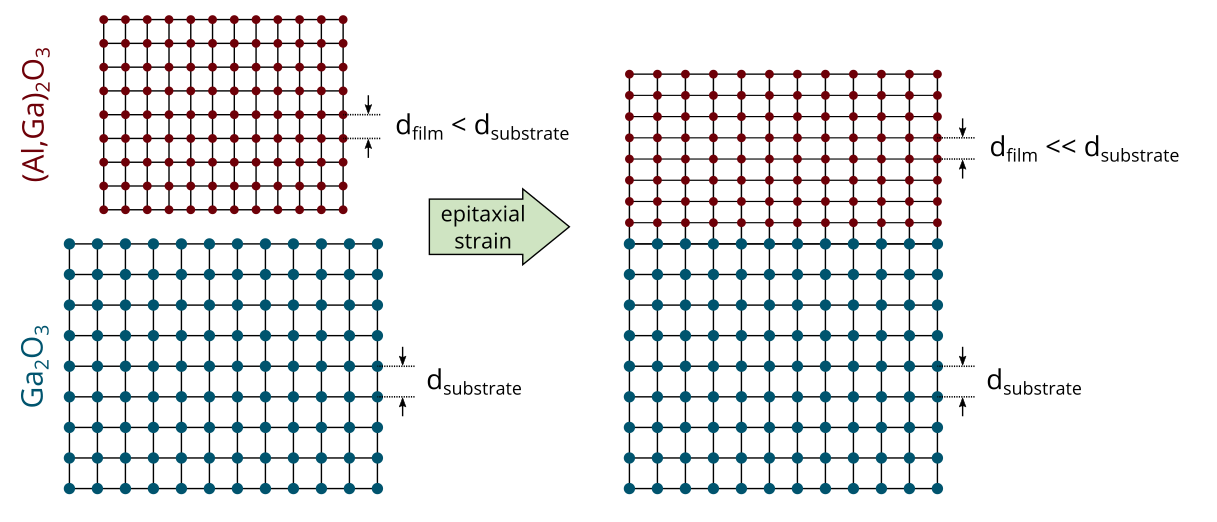


Bragg's law: $n\lambda = 2 d \sin\theta$

plot on logarithmic scale

(44.0, 47.0)

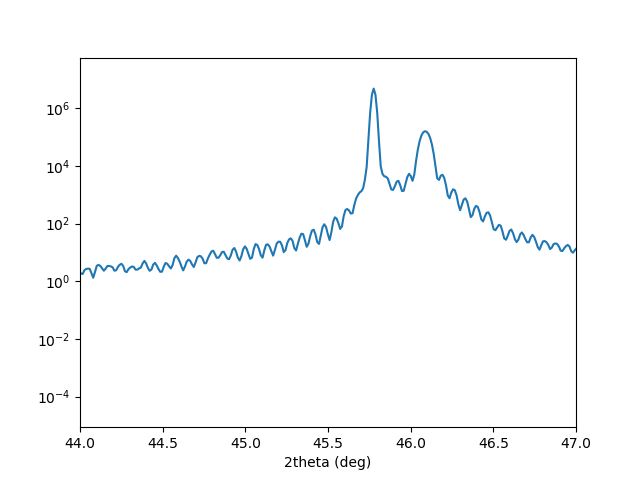

In [16]:
plt.figure()
plt.plot(twotheta, intensity)
plt.yscale("log")
plt.xlabel("2theta (deg)")
plt.xlim(44, 47)

**find the peak maximum position**

45.77639475438987 4768205.890344816


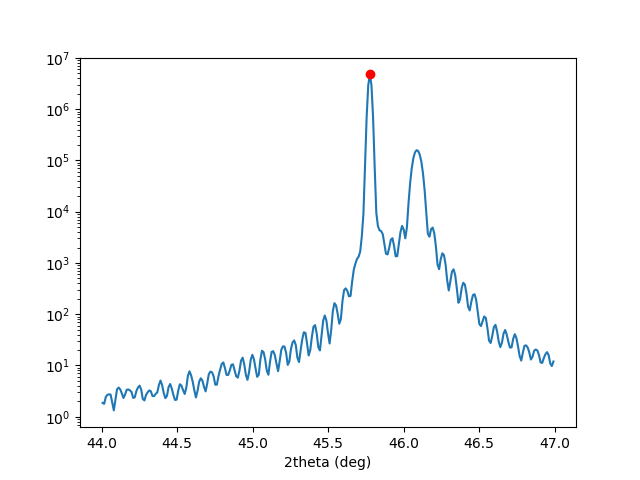

In [17]:
# mask out a region of interest
mask = (twotheta > 44) * (twotheta < 47)
tth_region = twotheta[mask]
I_region = intensity[mask]

plt.figure()
plt.plot(tth_region, I_region)
plt.yscale("log")
plt.xlabel("2theta (deg)")


imax = I_region.argmax()
tth_max = tth_region[imax]
I_max = I_region[imax]

print(tth_max, I_max)
plt.plot(tth_max, I_max,  "or")

### define a few common functions

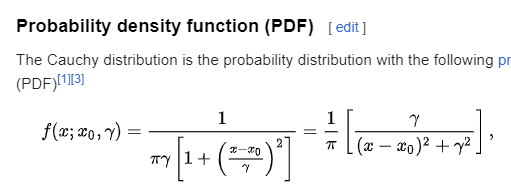

In [18]:
def lorentzian(x, x0, amp, w):
    return amp/(1 + ((x-x0)/w)**2) / (np.pi * w)

def gaussian(x, x0, amp, w, y0=0):
    return amp*np.exp(-(x-x0)**2/(2*w**2))+y0

def standard_normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def pvoigt(x, x0, amp, w, y0=0, eta=0.5):
    # a linear mix of lorentzian and gaussian
    return y0 + amp *    (eta  / (1+((x-x0)/w)**2) \
                     + (1-eta) * np.exp(-np.log(2)*((x-x0)/w)**2))

def sinc(x, x0, amp, w):
    zeta = (x-x0)/w + 1e-3j
    return amp*abs(np.sin(zeta)/zeta)**2


Test how these functions fit:

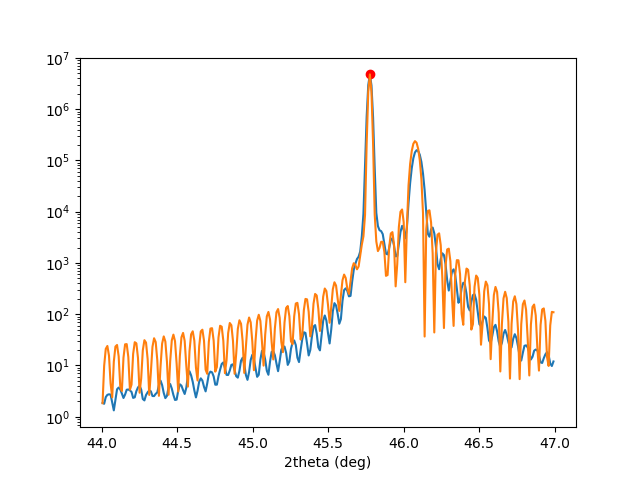

In [19]:
# mask out a region of interest
plt.figure()
plt.plot(tth_region, I_region)
plt.plot(tth_max, I_max,  "or")

plt.yscale("log")
plt.xlabel("2theta (deg)")

I_min = I_region.min()
sim = pvoigt(tth_region, tth_max, I_max, 0.01, eta=0.01)
sim += sinc(tth_region, tth_max+0.3, I_max/20, 0.02)
# sim += _XRD_film(tth_region, I_max/2e6, 100, c=11.8114)
# sim += I_min # add some background
plt.plot(tth_region, sim)



**DANGER: not an entirely physical model!!!**

### Let's formulate a model to fit

In [20]:
c = 12.214
c_rec = c*np.sin(np.radians(103.8))

In [21]:
parameters = lmfit.Parameters()
parameters.add("cen_sub", value=45.864, vary=False)
parameters.add("amp_sub", min=0, value=I_max/100)
parameters.add("w_sub", value=1e-3, min=1e-4, max=1e-2, vary=True)
# parameters.add("amp", min=0, value=1e-1)
# parameters.add("c_sub", value=11.8614, vary=False, min=11, max=13)
# parameters.add("N_sub", value=1e4, vary=True, min=1, max=1e5)


parameters.add("amp_film", min=0, value=I_max/20)
parameters.add("w_film", value=2e-2, min=1e-4, max=1e-1, vary=True)
parameters.add("cen_film", value=46.2, min=45.9, max=47, vary=True)
# parameters.add("c_film", value=11.9, vary=True, min=11, max=13)
# parameters.add("N_film", value=100, vary=True, min=1, max=1e4)


parameters.add("tth_offset", value=-0.1, vary=True, min=-1, max=1)
parameters.add("sigma", value=.005, vary=True, min=0, max=0.025)
# parameters.add("amp_film", min=0, value=I_max/2e6)

# parameters.add("logbg", value=-1, min=-10, max=10)
parameters

parameters["tth_offset"].value = tth_region[imax] - parameters["cen_sub"].value


In [22]:
def model(param, tth):
    pv = param.valuesdict()

    tth = tth - pv["tth_offset"]
    sim = lorentzian(tth, pv["cen_sub"], pv["amp_sub"], pv["w_sub"])
    sim += sinc(tth, pv["cen_film"], pv["amp_film"], pv["w_film"])
    # sim = _XRD_film(tth, pv["amp_sub"], pv["N_sub"], pv["c_sub"])
    # sim += _XRD_film(tth, pv["amp_film"], pv["N_film"], pv["c_film"])
    # sim += 10**pv["logbg"]
    
    return ndimage.gaussian_filter1d(sim, pv["sigma"]/(tth[1]-tth[0]))



def model2(param, tth):
    pv = param.valuesdict()

    tth = tth - pv["tth_offset"]
    sim = lorentzian(tth, pv["cen_sub"], pv["amp_sub"], pv["w_sub"])
    # sim += sinc(tth, pv["cen_film"], pv["amp_film"], pv["w_film"])
    # sim = _XRD_film(tth, pv["amp_sub"], pv["N_sub"], pv["c_sub"])
    sim += _XRD_film(tth, pv["amp_film"], pv["N_film"], pv["c_film"])
    # sim += 10**pv["logbg"]
    
    return ndimage.gaussian_filter1d(sim, pv["sigma"]/(tth[1]-tth[0]))


### Design of cost function - depends on problem

**Chi-square:**
$$ \chi^2 = \sum_i \frac{(O_i - E_i)^2}{\sigma_i^2} $$


$O_i\dots$ obervations / measurements

$E_i\dots$ expectations / calculations

$\sigma_i\dots$ estimated errors

**Reduced Chi-square**
$$ \chi^2_r = \frac {\chi^2} {n - m}$$

$n\dots$ number of observations

$m\dots$ number of fit parameters



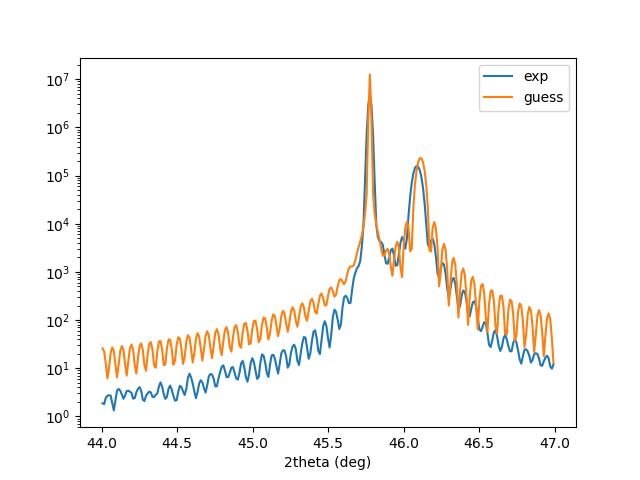

In [23]:
I_guess = model(parameters, tth_region)

plt.figure()
plt.plot(tth_region, I_region, label="exp")
plt.plot(tth_region, I_guess, label="guess")

plt.yscale("log")
plt.xlabel("2theta (deg)")
plt.legend()


In [24]:


def costfunction(param, tth, I_exp, logscale=False, gamma=0.25):
    """
        only returns the differences (O_i - E_i)/sigma_i
    """
    I_sim = model(param, tth)
    if logscale:
        diff = np.log(I_sim) - np.log(I_exp)
    else:
        
        diff = (I_exp - I_sim) / np.sqrt(I_exp)
    # diff = np.append(diff/1e3, I_sim/I_exp - 1)
    # diff = I_exp**gamma - I_sim**gamma
    # diff = I_sim/I_exp - 1
    if np.isinf(diff).any():
        print(param.pretty_print())
    return diff

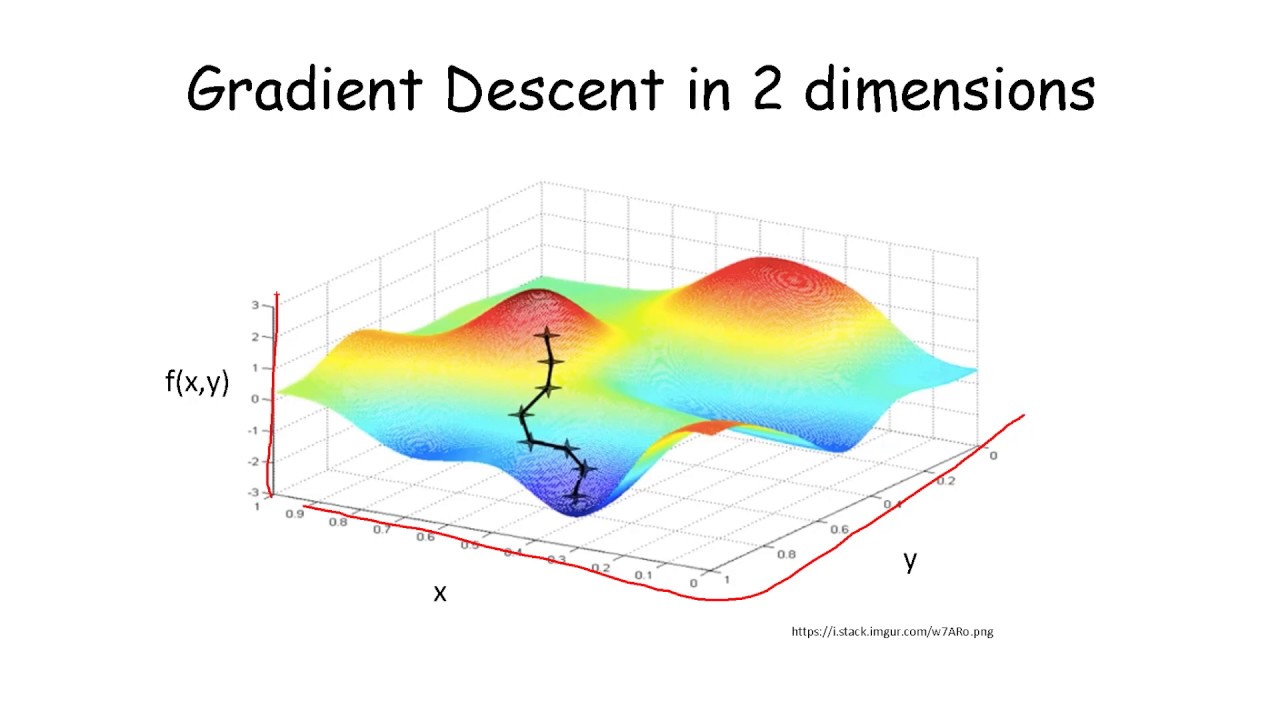

In [26]:
# fit = lmfit.minimize(costfunction, parameters, method="leastsq", args=(tth_region, I_region))




# def myfit(p0, tth_exp, I_exp, plot=True):
#     best_chired = np.inf
#     best_fit = None
#     cen_film = p0["cen_film"]
#     if plot:
#         with plt.ioff():
#             fig, ax = plt.subplots(1,1)
#             ax.set_ylabel("$\\chi_r$")
#             ax.set_xlabel("Fit-Run")
#         display_immediately(fig)
        
#     for num, x_start in enumerate(np.linspace(cen_film.min, cen_film.max, 11)):
#         cen_film.value = x_start
#         fit = lmfit.minimize(costfunction, p0, method="leastsq", args=(tth_exp, I_exp), max_nfev=4000)
#         if fit.redchi < best_chired:
#             best_chired = fit.redchi
#             bestfit = fit
#             print(fit.redchi)
#             if plot:
#                 ax.plot(num+1, best_chired, "ok")
#                 plt.yscale("log")
#                 fig.canvas.draw()
#                 time.sleep(0.1)
#     return bestfit
            

# fit = myfit(parameters, tth_region, I_region)
fit = lmfit.minimize(costfunction, parameters, method="leastsq", args=(tth_region, I_region, True))

In [27]:
fit

In [28]:
I_fit = model(fit.params, tth_region)
# fit.params["N_film"].value = 138
# I_fit = model(bestfit.params, tth_region)


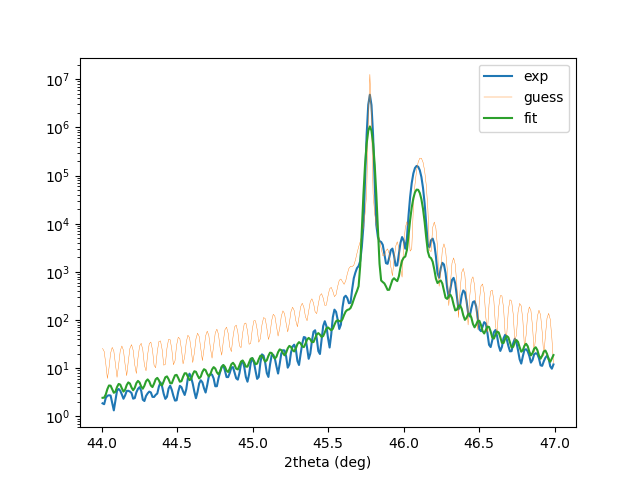

In [29]:
# mask out a region of interest
plt.figure()
plt.plot(tth_region, I_region, label="exp")
plt.plot(tth_region, I_guess, label="guess", lw=0.3)
plt.plot(tth_region, I_fit, label="fit")

plt.yscale("log")
plt.xlabel("2theta (deg)")
plt.legend()


# load calibration curve relating peak position to Al-content in $Al_{2x}Ga_{2(1-x)}O_{3}$

also make a polynomial (2nd order) fit allowing us to interpolate the calibration curve

In [30]:
x, tth_600 = np.loadtxt("tth_vs_x_strained.dat", skiprows=1, unpack=True)

Text(0, 0.5, '2theta of 600 reflection (deg)')

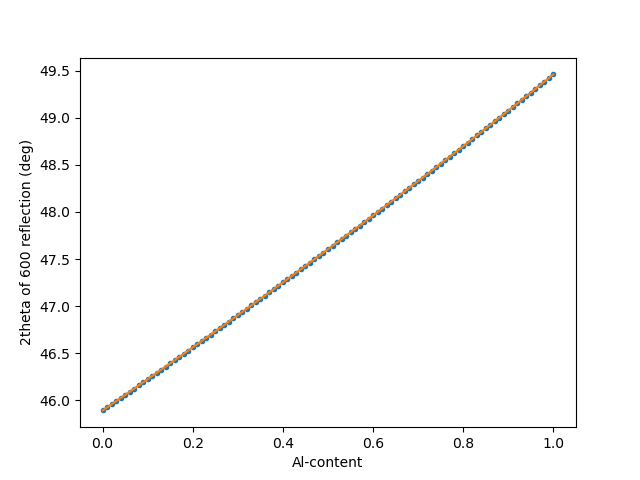

In [31]:
plt.figure()
plt.plot(x, tth_600, ".")

poly = np.polyfit(tth_600, x, 2)
x_vs_tth = np.poly1d(poly)


plt.plot(x_vs_tth(tth_600), tth_600, "-")
plt.xlabel("Al-content")
plt.ylabel("2theta of 600 reflection (deg)")


# now do everything again in a loop over all the scan files

(Al,Ga)2O3_theta-2theta_scan_2.xy 46.17772673872605 0.08554149886192874 Red-Chi2: 207.38860831910725
(Al,Ga)2O3_theta-2theta_scan_8.xy 46.34849083859358 0.13646183061592154 Red-Chi2: 166.72688999178183
(Al,Ga)2O3_theta-2theta_scan_6.xy 46.12754418170685 0.07050736602900542 Red-Chi2: 175.31178967991386
(Al,Ga)2O3_theta-2theta_scan_7.xy 46.32726888522933 0.1301537097779608 Red-Chi2: 171.6086839848018
(Al,Ga)2O3_theta-2theta_scan_1.xy 46.236464111534666 0.1030980864391502 Red-Chi2: 218.0105426910935
(Al,Ga)2O3_theta-2theta_scan_0.xy 46.42707787144651 0.1597718179643728 Red-Chi2: 177.91136175890955
(Al,Ga)2O3_theta-2theta_scan_9.xy 46.384943103399806 0.14728378657756735 Red-Chi2: 174.22011058888876
(Al,Ga)2O3_theta-2theta_scan_5.xy 46.486235715311054 0.1772672929450252 Red-Chi2: 204.47009970481594
(Al,Ga)2O3_theta-2theta_scan_10.xy 46.54060466651448 0.19330744306785164 Red-Chi2: 217.73531756452255
(Al,Ga)2O3_theta-2theta_scan_3.xy 46.26658999473494 0.11208577064370573 Red-Chi2: 166.1462395

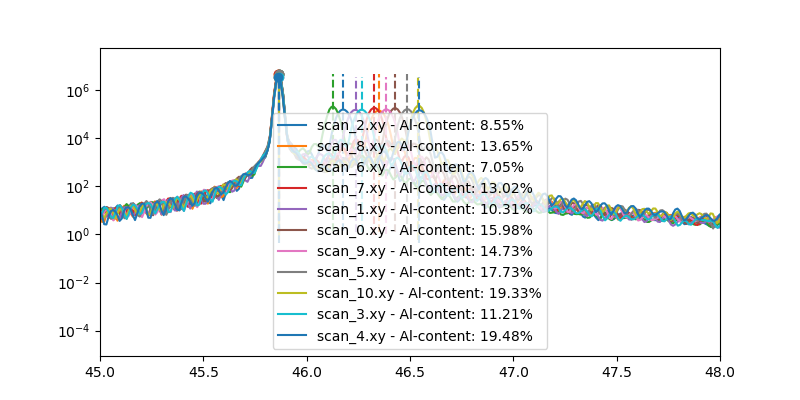

In [35]:
plt.figure(figsize=(8,4))


results = []

for path in files:
    arr = np.loadtxt(path, skiprows=1)
    twotheta = arr[:,0]
    intensity = arr[:,1]

    mask = (twotheta > 44) * (twotheta < 47)
    tth_region = twotheta[mask]
    I_region = intensity[mask]
    imax = I_region.argmax()


    

    parameters["tth_offset"].value = tth_region[imax] - parameters["cen_sub"].value
    
    # fit = myfit(parameters, tth_region, I_region, plot=False)
    fit = lmfit.minimize(costfunction, parameters, method="leastsq", args=(tth_region, I_region), max_nfev=4000)

    tth_off = fit.params["tth_offset"].value
    
    line = plt.plot(twotheta-tth_off, intensity)[0]
    maincolor = line.get_color()
    plt.plot(tth_region[imax]-tth_off, I_region[imax],  marker="o", color=maincolor)
    cen_subs = fit.params["cen_sub"].value
    cen_film = fit.params["cen_film"].value
    Al_content = x_vs_tth(cen_film)

    
    mylabel = "%s - Al-content: %.2f%%"%(path.split("2theta_")[1], Al_content*100)
    line.set_label(mylabel)
    
    results.append((path, cen_film, Al_content))

    print(path, cen_film, Al_content, "Red-Chi2:", fit.redchi)

    # plt.plot(tth_film, w,  "-")
    plt.plot([cen_subs, cen_subs], [I_region.min(), I_region.max()],  "--", color=maincolor)
    plt.plot([cen_film, cen_film], [I_region.min(), I_region.max()],  "--", color=maincolor)
    # plt.plot([cen, cen], [I_film.min(), I_film.pmax()],  "--r")
    plt.draw()


plt.legend()
plt.yscale("log")
plt.xlim(45, 48)
plt.savefig("peakpos.pdf")

In [36]:
np.savetxt("Al-content_fit.txt", np.array(results), fmt="%s")